# NBA referees analysis: endgame accuracy

This notebook provides analyses the accuracy of NBA referees with respect to whether a call is correct or not in the last 2 minutes of a game.

The analysis is carried out with two Bayesian models: 
- a simple beta-Bernoulli model and 
- a hiherchical beta-Bernoulli model.

For the latter the hierarchy is introduced by classifying referees with respect to three experience levels, namely less than 10 years, between 10 and 20 and more than 20 years of refereeing NBA games. 

The main conlclusion is that there is a significant difference in precision between referees with less than 10 years experience and more than 10 years experience.


## Research question
- Which referees are more likely to make a correct decision in th elast two minutes of the game? 
- What is the impact of referee's experience in making a correct call.

[Data set](https://github.com/polygraph-cool/last-two-minute-report) derived from the NBA's [Last Two Minute Report](http://official.nba.com/nba-last-two-minute-reports-archive/) by [Russell Goldenberg](http://russellgoldenberg.com/) of [The Pudding](https://pudding.cool/). NBA referee list can be found here: https://www.basketball-reference.com/referees/.

## Data collection and cleaning


In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [406]:
%%bash
DATA_URI=https://raw.githubusercontent.com/polygraph-cool/last-two-minute-report/32f1c43dfa06c2e7652cc51ea65758007f2a1a01/output/all_games.csv
DATA_DEST=/tmp/all_games.csv

if [[ ! -e $DATA_DEST ]];
then
    wget -q -O $DATA_DEST $DATA_URI
fi

In [407]:
orig_df = pd.read_csv(
    '/tmp/all_games.csv',
    index_col='play_id',
    parse_dates=['date']
)

In [408]:
#orig_df.to_csv('file.csv')
USECOLS = [
    'period',
    'seconds_left',
    'call_type',
    'committing_player',
    'disadvantaged_player',
    'review_decision',
    'away',
    'home',
    'ref_1',
    'date',
    'score_away',
    'score_home',
    'disadvantaged_team',
    'committing_team'
]
df = orig_df[USECOLS].dropna(axis=0)

In [409]:
def date_to_season(date):
    if date >= datetime.datetime(2017, 10, 17):
        return '2017-2018'
    elif date >= datetime.datetime(2016, 10, 25):
        return '2016-2017'
    elif date >= datetime.datetime(2015, 10, 27):
        return '2015-2016'
    else:
        return '2014-2015'
df = df.assign(season=lambda df: df['date'].apply(date_to_season))

########################

def seconds_left_to_mins(seconds_left):
    if seconds_left >= 100:
        return 100
    elif seconds_left >= 80:
        return 80
    elif seconds_left >= 60:
        return 60
    elif seconds_left >= 40:
        return 40
    elif seconds_left >= 20:
        return 20
    else:
        return 0
df = df.assign(time_left=lambda df: df['seconds_left'].apply(seconds_left_to_mins))

##########################

ref_lis = list(set(df.ref_1))
ref_lis.sort()
years_exp = []
for ref in ref_lis:
    ID = ref.split(' ')[1:][0][0:5] +ref[0:2]+'99r'
    #print(ID)
    try:
      df_re = pd.read_html(f'https://www.basketball-reference.com/referees/{ID.lower()}.html')
      #print(df_re)
      first, last = df_re[0][[('Unnamed: 0_level_0', 'Season')]].iloc[0,:][0], df_re[0][[('Unnamed: 0_level_0', 'Season')]].iloc[-2,:][0]
      first, last = int(first[0:4]), int(last[0:4])
      #print(last-first)
      years_exp.append(last-first)
    except:
      print(f'Url not found for {ref}.')
      years_exp.append('NAN')
        
def ref_exper(ref):
    idx = ref_lis.index(ref)
    return years_exp[idx]

df = df.assign(ref_exp=lambda df: df['ref_1'].apply(ref_exper))



Url not found for J.T. Orr.


In [410]:
########################

def exp_year_cls(ref_exp):
    try: 
       ref_exp = int(ref_exp) 
       if ref_exp >= 20:
        return 20
       elif ref_exp >= 10:
        return 10
       elif ref_exp >= 0:
        return 0   
    except:
        return 0
        
df = df.assign(ref_exp_cls=lambda df: df['ref_exp'].apply(exp_year_cls))

#df.ref_exp.value_counts()

In [411]:
df['review_decision'].value_counts().head(n=15)

CNC    8129
CC     4016
INC     981
IC      151
Name: review_decision, dtype: int64

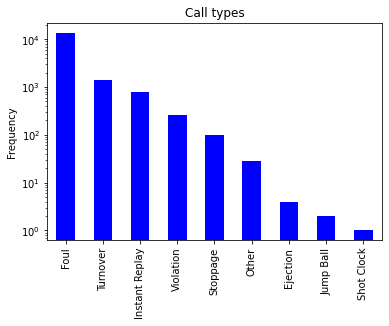

In [412]:
(orig_df['call_type']
        .str.split(':', expand=True)
        .iloc[:, 0]
        .value_counts()
        .plot(
            kind='bar',
            color='blue', logy=True, 
            title="Call types"
        )
        .set_ylabel("Frequency"));

In [413]:
df_ref_c = df.loc[:,['seconds_left','call_type','review_decision','ref_1','ref_exp_cls']]
df_ref_c = df_ref_c.loc[(df_ref_c.review_decision == 'CC')|(df_ref_c.review_decision == 'IC')].loc[df_ref_c.seconds_left<=120]

Text(0.5, 1.0, 'Number of Correct and Incorrect calls')

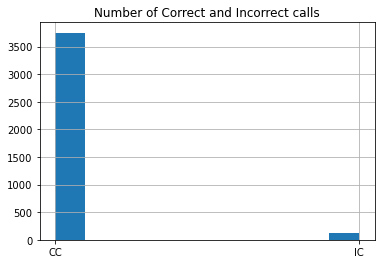

In [414]:
df_ref_c.review_decision.hist()
plt.title('Number of Correct and Incorrect calls')

Text(0.5, 1.0, 'Correct/Incorrect Calls according to seconds left')

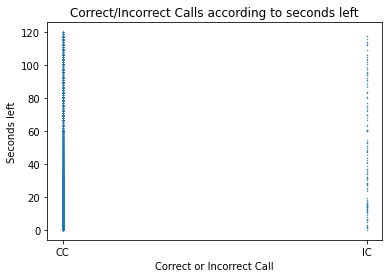

In [415]:
#df_ref_c.seconds_left.hist()
plt.plot(df_ref_c.review_decision, df_ref_c.seconds_left, 'o', markersize=.4)
plt.xlabel('Correct or Incorrect Call')
plt.ylabel('Seconds left')
plt.title('Correct/Incorrect Calls according to seconds left')

In [416]:
def call_to_binary(review_decision):
    out = 0
    if review_decision == 'CC':
        out = 1
    return out
df_ref_c = df_ref_c.assign(review_decision_bin=lambda df_ref_c: df_ref_c['review_decision'].apply(call_to_binary))

In [417]:
ref_num = len(set(df_ref_c.ref_1))
ref_list = list(set(df_ref_c.ref_1))
ref_list.sort()
def ref_to_index(ref_1):
    return ref_list.index(ref_1)

df_ref_c = df_ref_c.assign(ref_1_idx=lambda df_ref_c: df_ref_c['ref_1'].apply(ref_to_index))
df_ref_c.head()
#remove referees with less than 50 calls.
#df_ref_c.ref_1.value_counts()
#df_ref_c.groupby('ref_1').filter(lambda x : len(x)>39).ref_1.value_counts()
df_ref_c = df_ref_c[df_ref_c.ref_exp_cls != 'NAN']
#set(df_ref_c.ref_exp_cls)

## Beta-Bernoulli model
Denote by $n+1$ the number of plays with Foul calls,  $c$ the number of correct foul calls, by $R+1$ the number of referees. Indexing referees by $k=0,1,..,R$, we denote by $n_k$ the number of calls made made by referee $k$ and by $c_k$ the number of correct calls made by referee $k$. Let's study a simple Bernoulli trials model to estimate the probability $p_{k}$ where $k$ is a (leading) referee and $k(i)$ is the referee for the call $i$. The likelihood of (each realisation of) the model is
$$
y_i \sim p_{k(i)}^{[i]}(1-p_{k(i)})^{[i]},
$$
and the prior on each $p_{k}$ is $Beta(\alpha,\beta)$ distributed, so that our model is
$$
p(\theta|y)\propto p(y|\theta)p(\theta) =\Big(\prod_{i=0}^n p_{k(i)}^{[i]}(1-p_{k(i)})^{[i]}\Big)\prod_{j=0}^R \binom{n_j}{c_j}\frac{p_{j}^{\alpha-1}(1-p_{j})^{\beta-1}}{B(\alpha, \beta)}.
$$

In [418]:
import pymc3 as pm
import arviz as az

In [419]:
ref_num = len(set(df.ref_1))
idx = df_ref_c.ref_1_idx
observed_calls = df_ref_c.review_decision_bin

with pm.Model() as mod_bern:
    #Prior
    p = pm.Beta('p', alpha =1,beta=1, shape=ref_num)    
    #Likelihood
    y = pm.Bernoulli('y',  p[idx], observed = observed_calls)
    

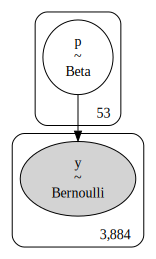

In [420]:
pm.model_to_graphviz(mod_bern)

In [421]:
N_TUNE = 1000
N_SAMPLES = 1000
SEED = 2398572
CHAINS =2
def sample(model, n_tune, n_samples, seed, chains):
    with model:
        full_trace = pm.sample(n_tune + n_samples, tune=n_tune, chains=CHAINS, random_seed=seed, return_inferencedata=True)
        
    return full_trace#full_trace[n_tune:]

In [422]:
trace_bern = sample(mod_bern, N_TUNE, N_SAMPLES, SEED, CHAINS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 11 seconds.


By plotting the trace we can see quite different performances in making a correct call between different referees.

In [423]:
def energy_plot(trace):
    energy = trace.sample_stats.energy[0]
    energy_diff = np.diff(energy)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.hist(energy - energy.mean(), bins=30,
            lw=0, alpha=0.5,
            label="Energy")
    ax.hist(energy_diff, bins=30,
            lw=0, alpha=0.5,
            label="Energy difference")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.legend()

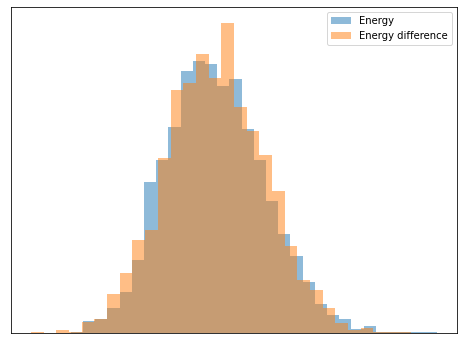

In [424]:
energy_plot(trace_bern)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

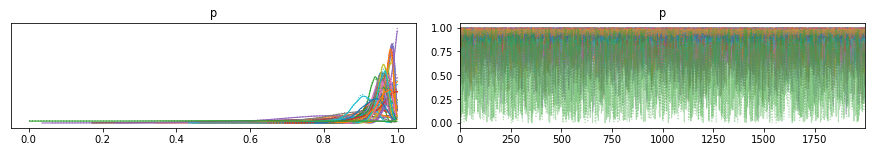

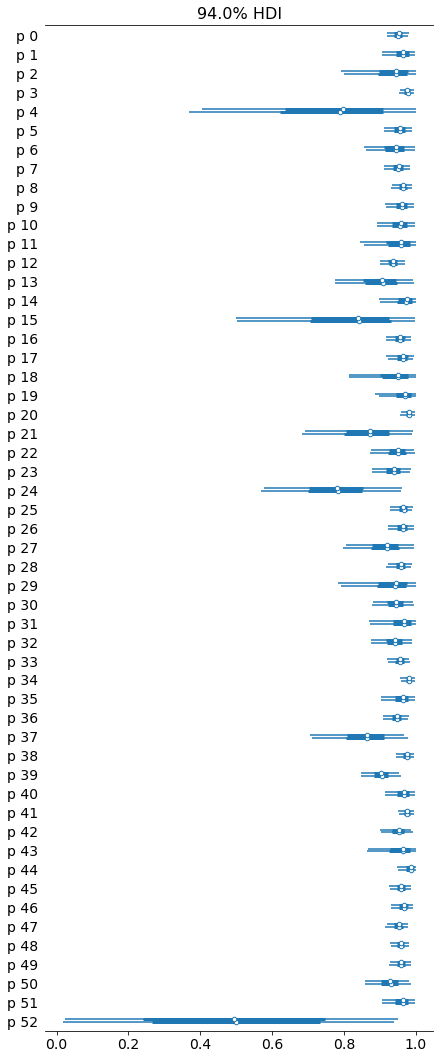

In [425]:
az.plot_trace(trace_bern) 
az.plot_forest(trace_bern) #ref_val = .9
    

In [426]:
trace_bern

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [427]:
with mod_bern:
    prior_checks = pm.sample_prior_predictive(samples=1000)
    ppc = pm.sample_posterior_predictive(trace_bern, samples=500)


/home/mas/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


## Hierarchical beta-Bernoulli

In [428]:
idx = df_ref_c.ref_1_idx
idx_al_be = []
for j in range(len(set(idx))):
    try:
     idx_al_be.append(int(list(set(df_ref_c.ref_exp_cls.loc[df_ref_c.ref_1_idx == j].values))[0]/10))
    except:
        print(j)
        pass
observed_calls = df_ref_c.review_decision_bin

with pm.Model() as mod_bern_hier:
    #Hyperprior
    '''
    alpha = pm.HalfCauchy('alpha', beta=1, shape =3)
    beta = pm.HalfCauchy('beta', beta=1, shape =3)
    '''
    alpha = pm.Uniform('alpha', lower=0, upper=20, shape =3)
    beta = pm.Uniform('beta', lower=0, upper=20, shape =3)
    #Prior
    p = pm.Beta('p', alpha=alpha[idx_al_be], beta=beta[idx_al_be], shape=len(set(idx)))
    #Likelihood
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)
 


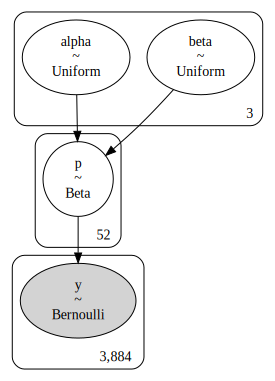

In [429]:
pm.model_to_graphviz(mod_bern_hier)

In [430]:
trace_bern_hier = sample(mod_bern_hier, N_TUNE, N_SAMPLES, SEED, CHAINS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 17 seconds.


In [431]:
trace_bern_hier

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

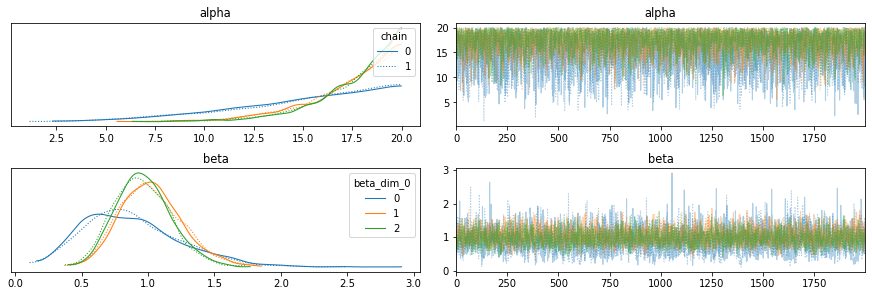

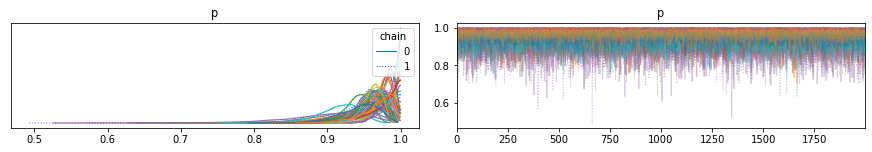

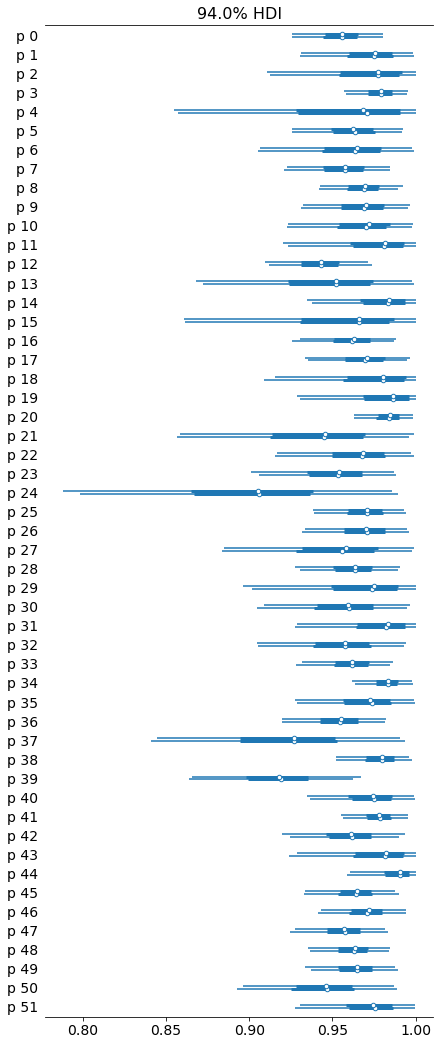

In [432]:
az.plot_trace(trace_bern_hier.posterior[['alpha','beta']], legend=True) 
az.plot_trace(trace_bern_hier.posterior['p'],legend=True) 
az.plot_forest(trace_bern_hier.posterior['p']) 

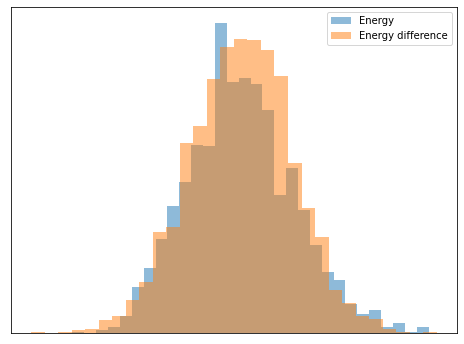

In [433]:
energy_plot(trace_bern_hier)

In [435]:
trace_bern_hier.posterior[['alpha','beta']]

<xarray.Dataset>
Dimensions:      (alpha_dim_0: 3, beta_dim_0: 3, chain: 2, draw: 2000)
Coordinates:
  * chain        (chain) int64 0 1
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * alpha_dim_0  (alpha_dim_0) int64 0 1 2
  * beta_dim_0   (beta_dim_0) int64 0 1 2
Data variables:
    alpha        (chain, draw, alpha_dim_0) float64 13.52 18.7 ... 18.9 17.11
    beta         (chain, draw, beta_dim_0) float64 0.7403 1.231 ... 1.252 1.065
Attributes:
    created_at:                 2021-05-24T06:48:34.359552
    arviz_version:              0.11.0
    inference_library:          pymc3
    inference_library_version:  3.10.0
    sampling_time:              17.35630464553833
    tuning_steps:               1000

Recall that the averate of a beta stable distribution is $\alpha/(\alpha+\beta)$ and the variance is $\alpha\beta/((\alpha+\beta)^2(\alpha+\beta+1))$.